In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

FS = 16 # fontsize
%matplotlib inline
plt.style.use('seaborn')
df1 = pd.read_csv("/Users/chenshaoling/ds-1001-spotify/Bofei/Billboard Data/Billboard_with_Spotify_features.csv")
df2 = pd.read_csv("/Users/chenshaoling/ds-1001-spotify/Shaoling/Billboard_lyrics.csv")

In [287]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Match BillBoard tracks with Genius Lyrics

In [288]:
features = [
 'title',
 'artist',
 'Spotify_ID',
 'Spotify_Popularity',
 'Is_Explicit',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence']
df1_1 = df1[features].drop_duplicates()

In [289]:
import Levenshtein
def isSameArtist1(name1, name2):
    return (name1.lower() in name2.lower()) or (name2.lower() in name1.lower()) or (name1.lower() == name2.lower())
def isSameArtist2(name1,name2):
    return (Levenshtein.ratio(name1.lower(), name2.lower()) > 0.5)

In [290]:
df12 = pd.merge(df1_1,df2,left_on =['title','artist'], 
         right_on = ['track_name','artist_name'], how = 'left')
df12_1 = df12.drop_duplicates(['title', 'artist'])

In [291]:
def matchArtist(row):
    subdf2 = df2[df2['track_name'] == row['title']]
    for i in subdf2.index:
        if isSameArtist1(subdf2['artist_name'][i], row['artist']):
            row['track_name'] = subdf2['track_name'][i]
            row['artist_name'] = subdf2['artist_name'][i]
            row['lyrics'] = subdf2['lyrics'][i]
    if row['track_name']:
        return row
    else:
        for i in subdf2.index:
            if isSameArtist2(subdf2['artist_name'][i], row['artist']):
                row['track_name'] = subdf2['track_name'][i]
                row['artist_name'] = subdf2['artist_name'][i]
                row['lyrics'] = subdf2['lyrics'][i]
        if row['track_name']:
            return row
        else:
            row['track_name'] = subdf2['track_name'][subdf2.index[0]]
            row['artist_name'] = subdf2['artist_name'][subdf2.index[0]]
            row['lyrics'] = subdf2['lyrics'][subdf2.index[0]]
            return row
nanIndex = df12_1[df12_1['track_name'].isnull()].index
df12_1.ix[nanIndex] = df12_1.ix[nanIndex].apply(matchArtist, axis = 1)

In [292]:
len(df12_1[df12_1['track_name'].isnull()])

505

In [293]:
del df12_1['Unnamed: 0']
del df12_1['artist_name']
del df12_1['track_name']

In [294]:
df12_1.shape[0]-df12_1.dropna().shape[0]

519

In [315]:
df12_2 = df12_1[['title','artist','lyrics']].dropna()
df12_2['lyrics'] = df12_2['lyrics'].str.replace('\n',' ').replace('\\','')
df12_2['lyrics'] = df12_2['lyrics'].apply(lambda x: re.sub(u"\\[.*?]", "", x))

# Word Frequency Analysis

In [316]:
import nltk
#from nltk.corpus import stopwords
nltk.download('stopwords')
from string import punctuation
punctuation = "".join([symbol for symbol in punctuation if symbol not in ["'", '"']])
punctuation += '–'

def clean_str(s):
    return s.translate(str.maketrans('', '', punctuation)).replace('\u200b', " ").strip().lower()

def tokenizeText(txt, remove_stop_words=True):
    """Splits a string of text into individual words"""
    stop_words = set(stopwords.words('english')) if remove_stop_words else []
    words = [w for w in clean_str(txt).split() if w not in stop_words]
    words = ['N-Word' if w in ['nigga', 'niggas'] else w for w in words]
    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chenshaoling/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [317]:
freq_dists, total_words = [], []
token_lists = list(map(tokenizeText, df12_2.lyrics))
tokens = [word for song in token_lists for word in song]
freq_dists.append(nltk.FreqDist(tokens))

In [318]:
freq_dists

[FreqDist({"i'm": 13820, 'like': 11340, 'yeah': 9325, 'know': 8549, 'got': 8532, 'N-Word': 8356, 'get': 7123, "ain't": 5350, 'love': 5341, 'go': 4464, ...})]

In [319]:
all_words = []
for lyrics in df12_2.lyrics:
     all_words.extend(lyrics.split(' '))
total_words.append(len(all_words))

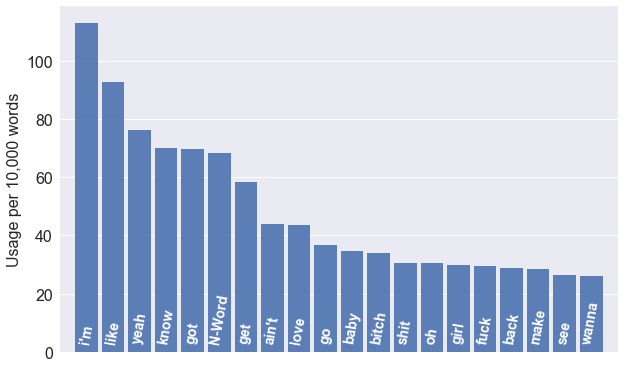

In [330]:
num_words = 20
fig, ax = plt.subplots(figsize=(10, 6), sharex=True)
for fd, total in zip(freq_dists, total_words):
    words, counts = zip(*[(word,count) for word, count in fd.most_common(num_words)])
    idxs = np.arange(num_words)
    counts = 10000*(np.asarray(counts)/total)

    ax.bar(idxs, counts, width=0.85, alpha=0.9)
    ax.set_ylabel('Usage per 10,000 words', fontsize=FS)
    ax.set_xticks([])
    ax.grid(True)
    
    params = {'fontsize': FS-2, 'rotation':80, 'va':'bottom', 'ha':'center',
              'color':'white', 'alpha':1, 'weight':'heavy', 'zorder':50}
    for idx, word in zip(idxs, words):
        ax.text(idx, 2.6, word, fontdict=params)
    
    y = ax.get_ylim()[1]
    x = idxs[-1]*1.04    
    xlim = ax.get_xlim()
    mid = np.mean(xlim)
    params = {'fontsize': FS+36, 'weight': 'heavy', 'ha': 'right', 'va':'bottom',
              'alpha': 1, 'color':np.array([219, 219, 219])/255, 'zorder':500}    
    
    ax.tick_params(labelsize=FS, direction='out')
    ax.set_xlim([-1, num_words])

plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9, hspace=0.1)
plt.show()


# Sentimental Analysis

In [339]:
df12_2_Index = df12_2['lyrics'].index

In [359]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
df = pd.DataFrame(columns=('track', 'pos', 'neu', 'neg','compound','Com_Index'))
sid = SentimentIntensityAnalyzer()
i = 0
for row in df12_2_Index:  
    sentence = df12_2['lyrics'][row] 
    comp = sid.polarity_scores(sentence) 
    if comp['compound'] >0.5:
        df.loc[i] = (df12_2['title'][row], comp['pos'], comp['neu'], comp['neg'], comp['compound'],'Pos')
    elif comp['compound'] < -0.5:
        df.loc[i] = (df12_2['title'][row], comp['pos'], comp['neu'], comp['neg'], comp['compound'],'Neg')
    else:
        df.loc[i] = (df12_2['title'][row], comp['pos'], comp['neu'], comp['neg'], comp['compound'],'Neu')
    i+=1

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chenshaoling/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [373]:
X = [pd.value_counts(df['Com_Index'])['Pos'],
    pd.value_counts(df['Com_Index'])['Neg'],
    pd.value_counts(df['Com_Index'])['Neu']]

([<matplotlib.patches.Wedge at 0x1a51aeac88>,
 [Text(0.0226208,1.09977,'Pos'),
  Text(-0.205506,-1.08063,'Neg'),
  Text(1.08463,-0.183241,'Neu')],
 [Text(0.0123386,0.599873,'49.345371%'),
  Text(-0.112094,-0.589436,'45.327315%'),
  Text(0.591617,-0.0999494,'5.327314%')])

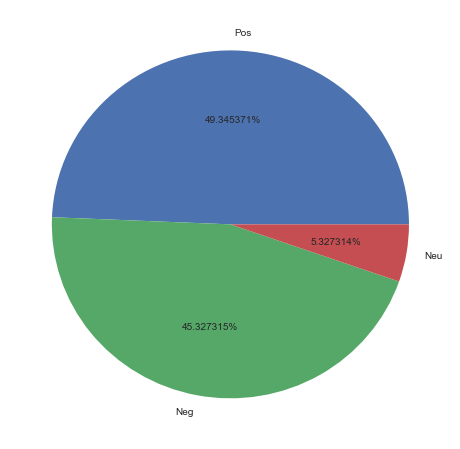

In [377]:
labels=['Pos', 'Neg', 'Neu']
fig = plt.subplots(figsize=(8, 8), sharex=True)
plt.pie(X,labels=labels,autopct='%2.6f%%')